# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from plotly.subplots import make_subplots

Представлены данные по трем регионам добычи нефти. Для удобного обращения с данными дадим безличным регионам названия в соответствии с тремя популярными марками нефти:
- brent - geo_data_0;
- wti - geo_data_1;
- sweet (сокращенно от Light Sweet) - geo_data_2

## 1.1 Регион добычи нефти марки *Brent*

In [2]:
brent = pd.read_csv('/datasets/geo_data_0.csv')
display(brent.head(),brent.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


None

Представленные данные включают идентификационный номер скважины, который нельзя рассматривать как признак в машинном обучении. Признаки 'f0', 'f1' и 'f2' являются числовыми и требуют масштабирования.

Посмотрим как распределены скважины по количеству запаов нефти.

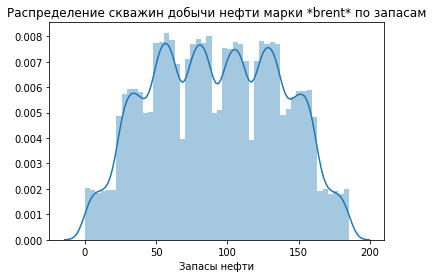

In [3]:
sns.distplot(brent['product'])
plt.title('Распределение скважин добычи нефти марки *brent* по запасам')
plt.xlabel('Запасы нефти')
plt.show()

Распределение скаажин по количеству запасов равномерно в диапазоне от 50 до 120 тыс. баррелей. Вцелом распределение напоминает нормальное.

Подготовим признаки месторождений для обучения модели. Так как все три признака числовые применим к ним масштабирование.

In [4]:
numeric= ['f0','f1','f2']
scaler = StandardScaler()

In [5]:
brent[numeric] = scaler.fit_transform(brent[numeric])
display(brent.describe())

,f0,f1,f2,product
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,2.287948e-17,-5.044853e-17,9.608314e-17,92.500000
std,1.000005e+00,1.000005e+00,1.000005e+00,44.288691
min,-2.189681e+00,-2.177430e+00,-4.491975e+00,0.000000
25%,-6.572397e-01,-8.941262e-01,-6.818784e-01,56.497507
50%,2.226500e-03,2.166008e-04,4.101360e-03,91.849972
75%,6.574259e-01,8.930937e-01,6.811217e-01,128.564089
max,2.135642e+00,2.168043e+00,4.156460e+00,185.364347


## 1.2 Регион добычи нефти марки *WTI*

In [6]:
wti = pd.read_csv('/datasets/geo_data_1.csv')
display(wti.head(),wti.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


None

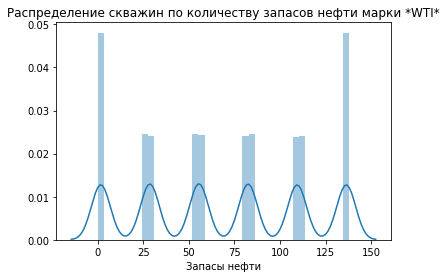

In [7]:
sns.distplot(wti['product'])
plt.xlabel('Запасы нефти')
plt.title('Распределение скважин по количеству запасов нефти марки *WTI*')
plt.show()

В отличие от месторождений марки Brent, месторождения марки WTI по своим запасам четко дифференцированы. Максимальное значение здесь ниже чем в предыдущем регионе.

Подготовим признаки к машинному обучению.

In [8]:
wti[numeric] = scaler.fit_transform(wti[numeric])
display(wti.describe())

,f0,f1,f2,product
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,-7.105427e-18,1.854517e-17,1.444533e-16,68.825000
std,1.000005e+00,1.000005e+00,1.000005e+00,45.944423
min,-3.652831e+00,-4.211458e+00,-1.474959e+00,0.000000
25%,-8.297949e-01,-6.780293e-01,-8.772907e-01,26.953261
50%,1.311571e-03,-3.240857e-03,-2.835602e-01,57.085625
75%,8.342420e-01,6.765366e-01,8.836555e-01,107.813044
max,3.154229e+00,4.595967e+00,1.482293e+00,137.945408


## 1.3 Регион добычи нефти марки *Light Sweet*

In [9]:
sweet = pd.read_csv('/datasets/geo_data_2.csv')
display(sweet.head(),sweet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


None

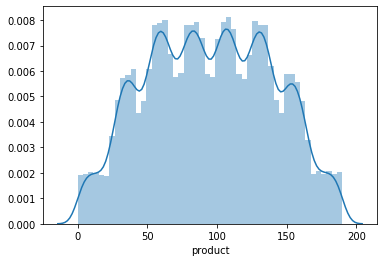

In [10]:
sns.distplot(sweet['product'])

Распределение запасов нефти марки *Light Sweet* похоже на распределение для марки *Brent*.

Подготовим признаки к машинному обучению.

In [11]:
sweet[numeric] = scaler.fit_transform(sweet[numeric])
display(sweet.describe())

,f0,f1,f2,product
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,2.241762e-17,-1.435296e-17,-1.391953e-16,95.000000
std,1.000005e+00,1.000005e+00,1.000005e+00,44.749921
min,-5.058801e+00,-4.092640e+00,-4.164608e+00,0.000000
25%,-6.722210e-01,-6.777239e-01,-6.808172e-01,59.450441
50%,4.272944e-03,-4.277388e-03,-3.135732e-03,94.925613
75%,6.677185e-01,6.736897e-01,6.804996e-01,130.595027
max,4.177880e+00,4.534699e+00,4.100928e+00,190.029838


# 2. Обучение и проверка модели

Так как предстоит работа с тремя базами данных создадим функцию, которая получает на вход признаки и целевые значения модели, а выдает: значения предсказанные по тестовым признакам; целевые тестовые значения; метрику R2 - коэффициент детерминации модели; метрику RMSE - квадратный корень из среднеквадратичной ошибки.

In [16]:
model = LinearRegression()
def product_prediction(features,target):
    features_train, features_test, target_train, target_test = train_test_split(
                        features,target,test_size=0.25,random_state=1)
    model.fit(features_train,target_train)
    predictions = model.predict(features_test)
    rmse = mean_squared_error(target_test,predictions)**0.5
    r2 = r2_score(target_test,predictions)
    return pd.Series(predictions,index=target_test.index), target_test, rmse, r2

Применим полученную функцию к имеющимся базам данных.

In [17]:
brent_predictions, brent_target, brent_rmse, brent_r2 = product_prediction(brent[numeric],brent['product'])
display(
    'Средний запас нефти марки *Brent* равен {:.0f} тыс. баррелей'.format(brent_predictions.mean()),
    'Коэффициент детерминации предсказания запаса нефти марки *Brent* равен {:.2f}'.format(brent_r2),
    'RMSE предсказания запаса нефти марки *Brent* равен {:.0f}'.format(brent_rmse))

'Средний запас нефти марки *Brent* равен 92 тыс. баррелей'

'Коэффициент детерминации предсказания запаса нефти марки *Brent* равен 0.28'

'RMSE предсказания запаса нефти марки *Brent* равен 38'

In [18]:
wti_predictions, wti_target, wti_rmse, wti_r2 = product_prediction(wti[numeric],wti['product'])
display(
    'Средний запас нефти марки *WTI* равен {:.0f} тыс. баррелей'.format(wti_predictions.mean()),
    'Коэффициент детерминации предсказания запаса нефти марки *WTI* равен {:.2f}'.format(wti_r2),
    'RMSE предсказания запаса нефти марки *WTI* равен {:.0f}'.format(wti_rmse))

'Средний запас нефти марки *WTI* равен 69 тыс. баррелей'

'Коэффициент детерминации предсказания запаса нефти марки *WTI* равен 1.00'

'RMSE предсказания запаса нефти марки *WTI* равен 1'

In [19]:
sweet_predictions, sweet_target, sweet_rmse, sweet_r2 = product_prediction(sweet[numeric],sweet['product'])
display(
    'Средний запас нефти марки *Light_Sweet* равен {:.0f} тыс. баррелей'.format(sweet_predictions.mean()),
    'Коэффициент детерминации предсказания запаса нефти марки *Light Sweet* равен {:.2f}'.format(sweet_r2),
    'RMSE предсказания запаса нефти марки *Light Sweet* равен {:.0f}'.format(sweet_rmse))

'Средний запас нефти марки *Light_Sweet* равен 95 тыс. баррелей'

'Коэффициент детерминации предсказания запаса нефти марки *Light Sweet* равен 0.20'

'RMSE предсказания запаса нефти марки *Light Sweet* равен 40'

# Выводы

Наилучшую точность предсказания модель дает для месторождений нефти марки *WTI* (коэффициент детерминации здесь равен 1), соответственно и погрешность предсказания объемов минимальная (RMSE равен 1 тыс. баррелей). Погрешность предсказания запасов нефти в месторождениях марок *Brent* и *Light Sweet* достигает 100%, в данном случае модель дает не многим лучший результат предсказания чем использование средних значений.

# 3. Подготовка к расчёту прибыли

Введем исходные данные

In [20]:
budget = 10E9 #Бюджет на разработку скважин в регионе
barrel_unit_price = 450E3 #Доход с каждой единицы продукта составляет 450 тыс. рублей
point_number = 500 #При разведке региона исследуют 500 точек
best_point_number = 200 #200 лучших для расчёта прибыли

Рассчитаем объём запасов нефти в месторождениях необходимый для безубыточной разработки новой скважины

In [21]:
zero_profit = budget/barrel_unit_price/best_point_number
print('Объём нефти для безубыточной разработки новой скважины {:.0f} тыс. баррелей'.format(zero_profit))

Объём нефти для безубыточной разработки новой скважины 111 тыс. баррелей


Запасы нефти для безубыточной разработки новой скважины превышает средние запасы нефти во всех регионах. Посмотрим какая доля скважин в каждом регионе не является убыточной.

In [22]:
display('Доля месторождений нефти марки *Brent* приносящих прибыль равна {:.2f}'.format(
    brent.query('product > @zero_profit').shape[0]/brent.shape[0]),
       'Доля месторождений нефти марки *WTI* приносящих прибыль равна {:.2f}'.format(
    wti.query('product > @zero_profit').shape[0]/wti.shape[0]),
        'Доля месторождений нефти марки *Light Sweet* приносящих прибыль равна {:.2f}'.format(
    sweet.query('product > @zero_profit').shape[0]/sweet.shape[0]))

'Доля месторождений нефти марки *Brent* приносящих прибыль равна 0.37'

'Доля месторождений нефти марки *WTI* приносящих прибыль равна 0.17'

'Доля месторождений нефти марки *Light Sweet* приносящих прибыль равна 0.38'

# Выводы

В регионах по добыче нефти марок *Brent* и *Light Sweet* доля прибыльных скважин составляет 40%, в то время как для *WTI* таких месторождений в два раза меньше. Соответственно, выбирая из 500 возможных месторождений 200 лучших (40%), для марок *Brent* и *Light Sweet* мы должны получать все прибыльные месторождения, а в случае месторождений марки *WTI* неизбежно захватываем часть убыточных.

Однако обученная раннее модель идеально предсказывает запасы именно в месторождениях *WTI*, а значит здесь мы точно выберем месторождения приносящие прибыль. В то время как в регионах добычи нефти марок *Brent* и *Light Sweet* компания по прежнему работает в слепую.

# 4. Расчёт прибыли и рисков 

## 4.1 Подготовка функции прибыли (рентабельности)

Подготовим функцию для расчета прибыли и рисков (вероятности убыточности разработки месторождений). Вместо метрики прибыли будем использовать относительную величину - рентабельность (отношение прибыли к валовой выручке), которая дополнительно показывает насколько велика прибыль, а так же удобнее воспринимается.

In [23]:
state = RandomState(12)
def profitability(product_volume_predictions,product_volume_test):
    predicted_profitability = [] #предсказанная рентаблеьность
    predicted_risk_count = 0 #количество предсказанных убыточных случаев
    test_profitability = [] #тестовая рентаблеьность
    test_risk_count = 0 #количество тестовых убыточных случаев
    for i in range(1000):
        volume = pd.DataFrame(product_volume_predictions,columns=['predicted_volume'])
        volume['test_volume'] = product_volume_test
        best_predictions = volume.sample(n=point_number,replace=True,random_state=state
                                  ).sort_values(by='predicted_volume',ascending=False).head(best_point_number)
        predicted_income = best_predictions['predicted_volume'].sum() * barrel_unit_price
        predicted_profitability.append((predicted_income - budget)/predicted_income)
        test_income = best_predictions['test_volume'].sum() * barrel_unit_price
        test_profitability.append((test_income - budget)/test_income)
        if (predicted_income - budget)/predicted_income < 0:
            predicted_risk_count += 1
        if (test_income - budget)/test_income < 0:
            test_risk_count += 1
    predicted_profitability = pd.Series(predicted_profitability)
    predicted_risk = predicted_risk_count/1000*100
    test_profitability = pd.Series(test_profitability)
    test_risk = test_risk_count/1000*100
    return predicted_profitability, predicted_risk, test_profitability, test_risk

Применим полученную функцию к данным по каждому региону.

In [20]:
brent_predicted_profitability, brent_predicted_risk, brent_test_profitability, brent_test_risk = profitability(
    brent_predictions,brent_target)

In [21]:
wti_predicted_profitability, wti_predicted_risk, wti_test_profitability, wti_test_risk = profitability(
    wti_predictions,wti_target)

In [22]:
sweet_predicted_profitability, sweet_predicted_risk, sweet_test_profitability, sweet_test_risk = profitability(
    sweet_predictions,sweet_target)

Получим для каждого региона предсказанные: среднюю рентабельность, 95%-й доверительный интервал рентабельности, и риск убытков; а так же сравним их с тестовыми данными.

## 4.2 Расчет рентабельности разработки месторождений нефти марки  *Brent*

In [23]:
brent_stats = pd.DataFrame([[brent_predicted_profitability.mean(),
                            brent_predicted_profitability.quantile(0.05),
                            brent_predicted_risk],
                            [brent_test_profitability.mean(),
                            brent_test_profitability.quantile(0.05),
                            brent_test_risk]],
                           index = ['brent_predicted','brent_test'],
                           columns = ['mean_profitability','profitability_quantile_5%','risk,%'])
display(brent_stats)

,mean_profitability,profitability_quantile_5%,"risk,%"
brent_predicted,0.034061,0.016704,0.2
brent_test,0.040878,-0.001528,6.0


Средняя рентабельность разработки месторождений нефти марки *Brent* предсказанная моделью 0.034, что на 0.007 ниже чем может быть получено при разработке этих скважин (по тестовым данным). Однако риск убытков по тестовым данным так же значительно выше чем по данным предсказанным моделью. Как мы видели выше, модель плохо справилась с этими данными и доверяя полученным предсказаниям можно получить убыточную рентабельность с вероятностью 6%.

Посмотрим варианты рентабельности рассчитанные по данным предсказанным обученной моделью и по тестовым данным.

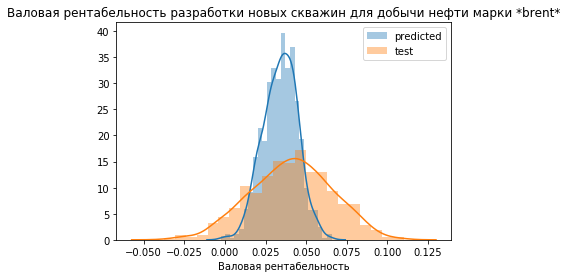

In [24]:
sns.distplot(brent_predicted_profitability, hist_kws={'label':'predicted'})
sns.distplot(brent_test_profitability, hist_kws={'label':'test'})
plt.legend()
plt.xlabel('Валовая рентабельность')
plt.title('Валовая рентабельность разработки новых скважин для добычи нефти марки *brent*')
plt.show()

Предсказанное и тестовое распределение рентабельности близки к нормальному распределению с примерно одинаковым средним, однако стандартное отклонение по тестовым данным существенно больше чем по предсказанным моделью. По-видимому модель плохо предсказвает максимальные и минимальные значения. Проверим это. Построим ящик с усами для предсказанных и тестовых значений.

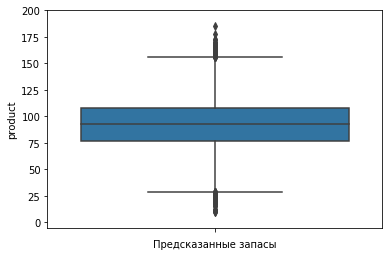

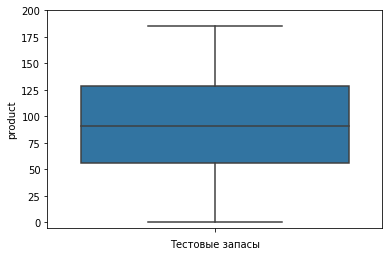

In [25]:
sns.boxplot(y=brent_predictions)
plt.xlabel('Предсказанные запасы')
plt.ylabel('product')
plt.ylim(-5,200)
plt.show()
sns.boxplot(y=brent_target)
plt.xlabel('Тестовые запасы')
plt.ylim(-5,200)
plt.show()

Действительно в предсказанных моделью месторождениях мало скважин с очень малым и очень большим запасом нефти.

## 4.3 Расчет рентабельности разработки месторождений нефти марки  *WTI*

In [26]:
wti_stats = pd.DataFrame([[wti_predicted_profitability.mean(),
                            wti_predicted_profitability.quantile(0.05),
                            wti_predicted_risk],
                            [wti_test_profitability.mean(),
                            wti_test_profitability.quantile(0.05),
                            wti_test_risk]],
                           index = ['wti_predicted','wti_test'],
                           columns = ['mean_profitability','profitability_quantile_5%','risk,%'])
display(wti_stats)

,mean_profitability,profitability_quantile_5%,"risk,%"
wti_predicted,0.045503,0.013967,1.1
wti_test,0.045624,0.014192,1.1


Модель практически идеально предсказывала запасы нефти марки *WTI*. И это отразилось в расчете рентабельности разработки этих месторождений. Она даже выше (на 0.005) чем для месторождений марки *Brent*, при меньших средних запасах. Риски убытков так же допустимые - 1.1%. Разработка данных месторождений с вероятностью 95% покажет рентабельность не ниже 1.4%, при средних 4.6%.

Сравним распределение рентабельности разработки новых скважин для добычи нефти марки *WTI* предсказанную моделью и тестовую.

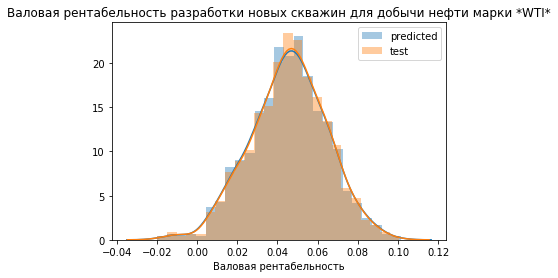

In [27]:
sns.distplot(wti_predicted_profitability, hist_kws={'label':'predicted'})
sns.distplot(wti_test_profitability, hist_kws={'label':'test'})
plt.legend()
plt.xlabel('Валовая рентабельность')
plt.title('Валовая рентабельность разработки новых скважин для добычи нефти марки *WTI*')
plt.show()

Как и ожидалось распределения совпадают.

## 4.4 Расчет рентабельности разработки месторождений нефти марки  *Light Sweet*

In [28]:
sweet_stats = pd.DataFrame([[sweet_predicted_profitability.mean(),
                            sweet_predicted_profitability.quantile(0.05),
                            sweet_predicted_risk],
                            [sweet_test_profitability.mean(),
                            sweet_test_profitability.quantile(0.05),
                            sweet_test_risk]],
                           index = ['sweet_predicted','sweet_test'],
                           columns = ['mean_profitability','profitability_quantile_5%','risk,%'])
display(sweet_stats)

,mean_profitability,profitability_quantile_5%,"risk,%"
sweet_predicted,0.028727,0.013901,0.0
sweet_test,0.036436,-0.003610,6.5


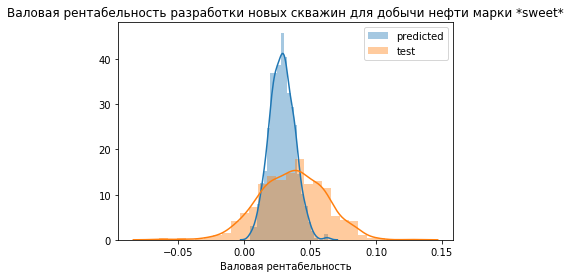

In [29]:
sns.distplot(sweet_predicted_profitability, hist_kws={'label':'predicted'})
sns.distplot(sweet_test_profitability, hist_kws={'label':'test'})
plt.legend()
plt.xlabel('Валовая рентабельность')
plt.title('Валовая рентабельность разработки новых скважин для добычи нефти марки *sweet*')
plt.show()

Как уже наблюдалось при расчете рентабельности разработки месторождений нефти марки *Brent*, плохо обученная модель дает некачественные предсказания не позволяющие выделить скважины с большими запасами, приносящие бОльшую прибыль. А не выявленные "пустые" месторождения увеличивают риск убыточности разработки.

# 5 Выводы и рекомендации

Проведенный анализ представленных данных трех геологоразведочных регионов перспективной добычи нефти показал, что:
- наибольшей долей потенциально прибыльных месторождений обладают регионы geo_data_0 и geo_data_2 - примерно 40%;
- из-за сложности предсказания количества запасов нефти в месторождениях регионов geo_data_0 и geo_data_2, разработка нефти здесь связана с повышенными рисками убытков - примерно 6%;
- предпочтительным регионом для бурения новой скважины можно считать регион geo_data_1: рентабельность не ниже 1.4% (при доверительной вероятности 95%), при средних 4.6%; риск убыточной разработки на уровне 1.1%;
- объем запасов нефти в месторождениях региона geo_data_1 возможно предсказать с достаточно высокой точностью, поэтому в случае отдельно взятой скважины возможно получения максимальной рентабельности - порядка 10%.